# Bank Customer Churn -  XGBOOST 


# Importando Bibliotecas 


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (roc_auc_score, confusion_matrix, precision_score, recall_score, 
                             f1_score, accuracy_score, roc_curve, auc)
from imblearn.over_sampling import SMOTE  # Adicionando o SMOTE para balanceamento
import xgboost as xgb
import optuna
import warnings
from datetime import datetime, timedelta
import os
import time
import matplotlib.cm as cm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


# Análise Exploratória (EDA) & Data Wrangling 


In [18]:
# base de dados
base_original = pd.read_csv('/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv', sep=',')

#primeiras linhas 
primeiras_linahs = base_original.head()
print(primeiras_linahs)

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58

Analisando primeiras impressões da base de dados


In [19]:
#Dimensões da base de dados
print("Numero de linhas:", base_original.shape[0]) #10.000 linhas originais.
print("Numero de colunas:", base_original.shape[1])# 18 Colunas (variaveis) originais.


Numero de linhas: 10000
Numero de colunas: 18


In [20]:
#Verificando nome das colunas e tipos

tipos = base_original.dtypes
print(tipos)

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object


In [21]:
#checando se há valores nulos 

tem_null=base_original.isnull().sum()  #como podemos ver não há valores nulos em nenhuma das variáveis

print(tem_null)



RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


In [22]:
# Resumo estatistico da base original
describe_original = base_original.describe()
print(describe_original)

         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

In [23]:
# Limpando variavéis que não tem interferencia na analise 

df = base_original[['CreditScore','Gender','Geography','Age','Tenure','Balance',
                   'NumOfProducts','HasCrCard','IsActiveMember',
                   'EstimatedSalary','Complain','Satisfaction Score',
                   'Card Type','Point Earned','Exited'
                   ]]


In [24]:
#Resumo estatistico das varaiveis Quanti

#quanti 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore','Age', 'Tenure','Point Earned']]

resumo_estati_quant=quanti.describe() 
# Aplicar formatação para ter 1 casa decimal e separador de milhar (invertendo ponto e vírgula)
resumo_estati_quant_formatado = resumo_estati_quant.applymap(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))

print(resumo_estati_quant_formatado)


      EstimatedSalary    Balance CreditScore       Age    Tenure Point Earned
count        10.000,0   10.000,0    10.000,0  10.000,0  10.000,0     10.000,0
mean        100.090,2   76.485,9       650,5      38,9       5,0        606,5
std          57.510,5   62.397,4        96,7      10,5       2,9        225,9
min              11,6        0,0       350,0      18,0       0,0        119,0
25%          51.002,1        0,0       584,0      32,0       3,0        410,0
50%         100.193,9   97.198,5       652,0      37,0       5,0        605,0
75%         149.388,2  127.644,2       718,0      44,0       7,0        801,0
max         199.992,5  250.898,1       850,0      92,0      10,0      1.000,0


<ipython-input-24-f3e9900ce3e9>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  resumo_estati_quant_formatado = resumo_estati_quant.applymap(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))


In [25]:
#%% Resumo estatistico das varaiveis Quali (tabelas de frequencias)
quali = df[['HasCrCard', 'IsActiveMember', 'Geography','Gender'
            ,'Complain','Exited','Card Type']]
quali = quali.astype('object')

print(quali['HasCrCard'].value_counts())
print(" ")
print(quali['IsActiveMember'].value_counts())
print(" ")
print(quali['Geography'].value_counts())
print(" ")
print(quali['Gender'].value_counts())
print(" ")
print(quali['Complain'].value_counts())
print(" ")
print(quali['Card Type'].value_counts())
print(" ")
print(quali['Exited'].value_counts())

HasCrCard
1    7055
0    2945
Name: count, dtype: int64
 
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
 
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
 
Gender
Male      5457
Female    4543
Name: count, dtype: int64
 
Complain
0    7956
1    2044
Name: count, dtype: int64
 
Card Type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64
 
Exited
0    7962
1    2038
Name: count, dtype: int64


In [26]:
# Verificando tipos das variaveis quali
quali.dtypes

HasCrCard         object
IsActiveMember    object
Geography         object
Gender            object
Complain          object
Exited            object
Card Type         object
dtype: object

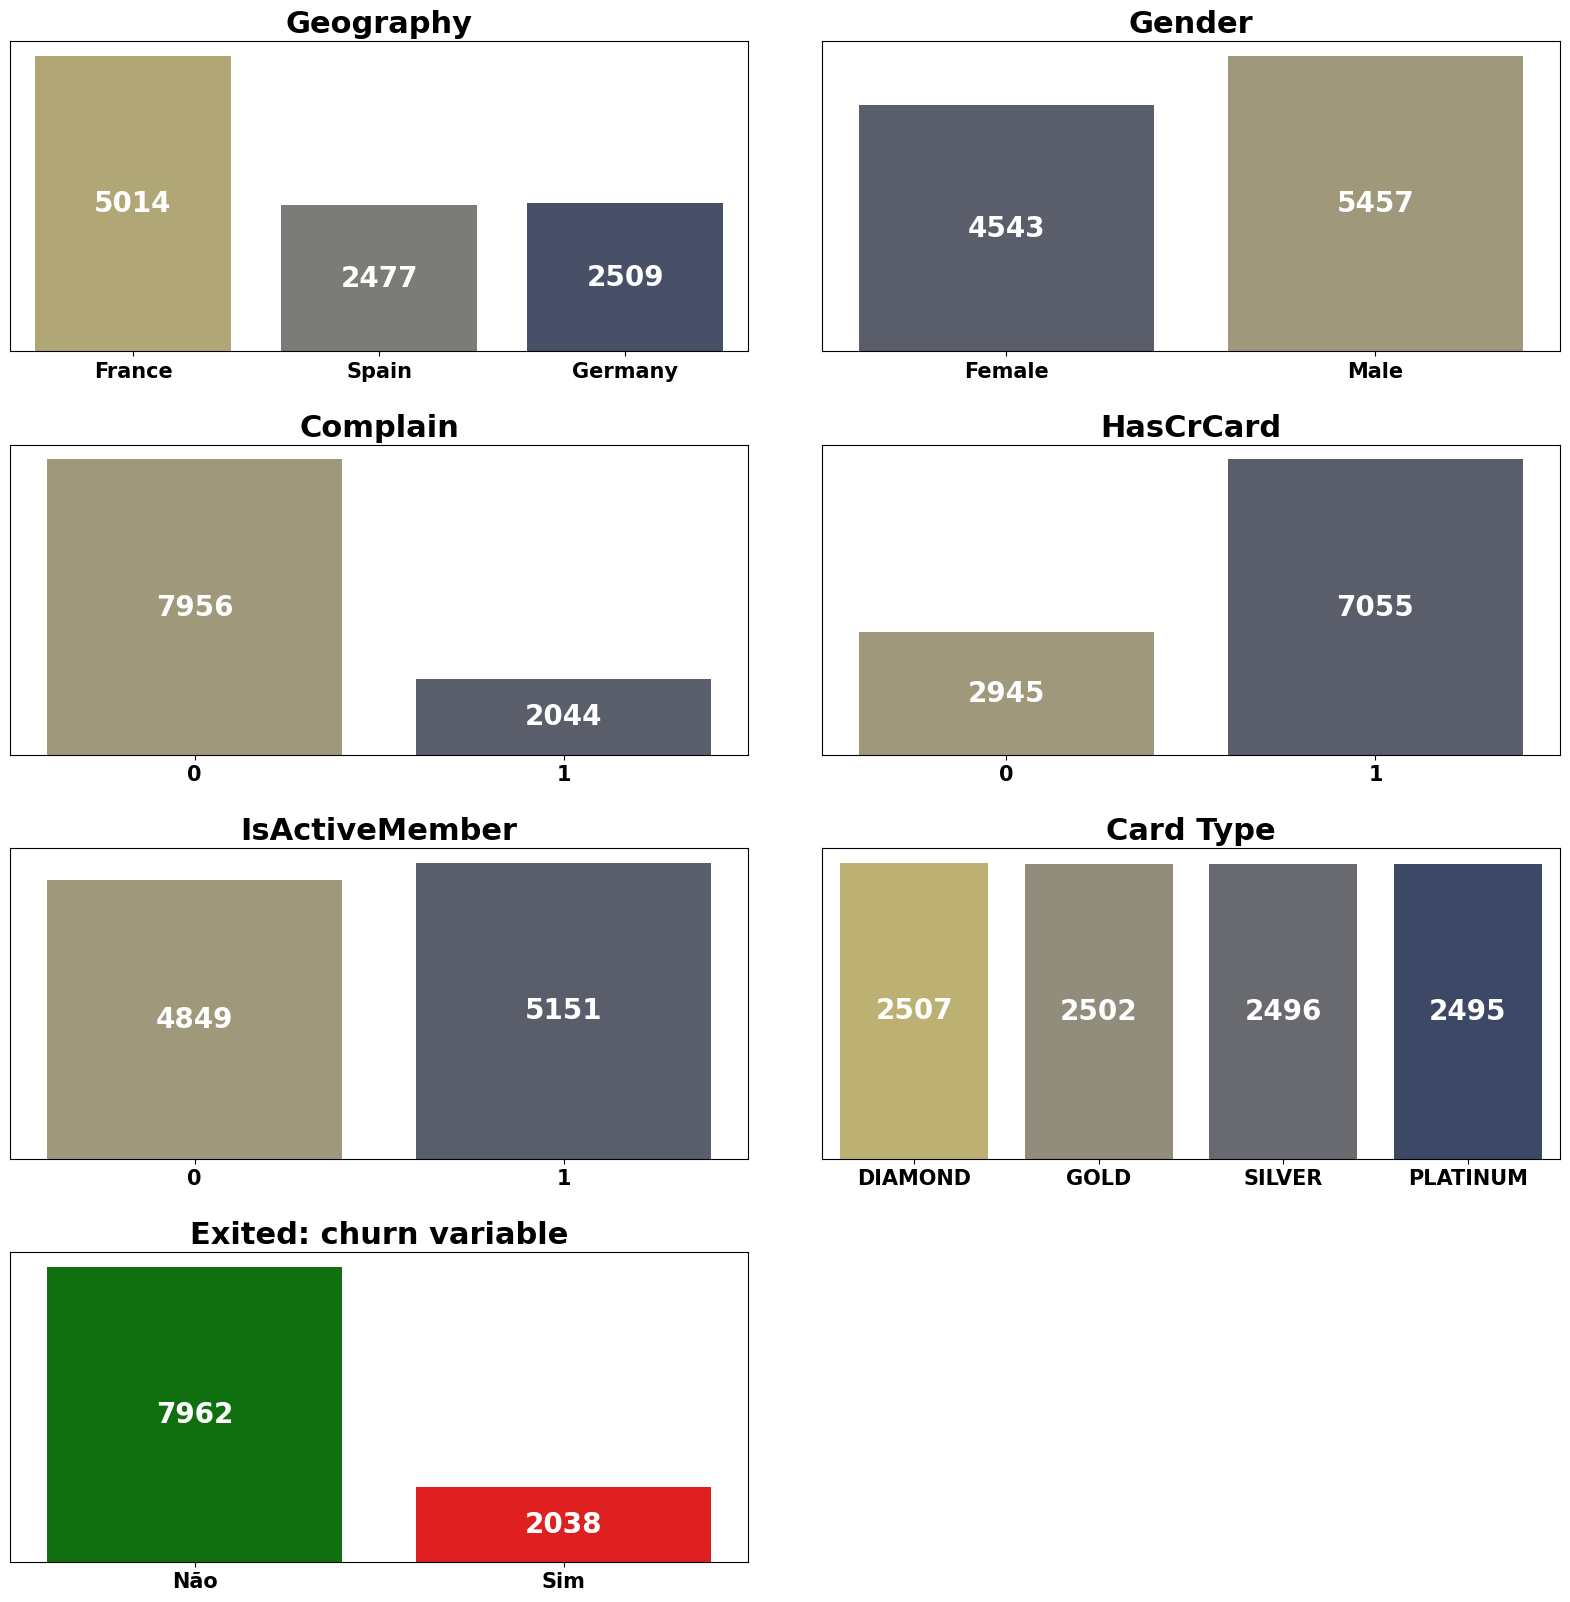

In [27]:
#%%Analises gráficas: variaveis Categóricas 


def add_value_labels(ax):#funcao que adc rótulos de dados com fundo arredondado nas barras do gráfico
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()  # Obtém a cor da barra
        # rótulo no centro da barra com fundo da mesma cor da barra e bordas arredondadas
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',  # Formata o valor para int
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))


#plt.suptitle('Frequência absoluta\n das variaveis qualitativas', fontsize=45)

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', palette='cividis_r', data=base_original, ax=ax1)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax1)

# Gender
plt.subplot(5, 2, 2)
ax2 = plt.gca()
ax2.set_title('Gender', fontsize=22, fontweight='bold')
sns.countplot(x='Gender', palette='cividis', data=base_original, ax=ax2)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax2)
# Complain
plt.subplot(5, 2, 3)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', palette='cividis_r', data=base_original, ax=ax10)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 4)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', palette='cividis_r', data=base_original, ax=ax5)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 5)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', palette='cividis_r', data=base_original, ax=ax6)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', palette='cividis_r', data=base_original, ax=ax10)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# Exited
plt.subplot(5, 2, 7)
ax7 = plt.gca()
ax7.set_title('Exited: churn variable', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', palette=custom_palette, data=base_original, ax=ax7)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0,fontweight='bold')
plt.yticks([])
add_value_labels(ax7)


ax7.set_xticks([0, 1])  # Define os ticks manualmente
ax7.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')  # Rótulos personalizados
add_value_labels(ax7)


# ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.3, wspace=0.1)




# ANÁLISES DE FREQUENCIAS

# - Maioria dos clientes é da França 

# - Os clientes são bem distribuídos entre os generos masculino e feminino 

# - a maioria dos clientes tem de 1 a 9 anos, aparentemente clientes com mais de 9 anos não permanecem (isso deve ser investigado pela quantidade de churn por Tenure)
#   e tem poucos clientes com menos de 1 ano, oque pode ser poucos novos clientes ou um churn elevado nos clientes com menos de 1 ano  (isso deve ser investigado pela quantidade de churn por Tenure)

# - Clientes tem em grande maioria entre 1 e 2 produtos, mantendo um equilibrio entre essas duas categorias. 

# - A maioria dos clientes tem cartão de crédito (70,55%)

# - Clientes ativos e não ativos estão bem distribuídos 

# - Nossa variavel de estudo está desbalanceada, como o objetivo é prever
#  principalmente quem churn é verdadeiro (embora vamos avaliar a capacidade de prever o não churn tbm para obtermos um bom modelo)
#  OBS: PESQUISAR SOBRE APLICAR MODELAGEM PRABABILISTICA E SE TEM COMO APLICAR AS DUAS (BINÁRIA E PROBABILISTICA JUNTAS) PORQUE AOS INVES DE SIM OU NAO A PROBABILISTICA RETORNA UM % DE CHANCE DE CHURN, ISSO PODE SER UTIL DIVIDIR AS ACOES E OS RECURSOS EM CASOS PRATICOS 
 
# - A maioria dos clientes não tem reclamação ( provavelmente quem reclamou churneou, isso explica a correlacao absoluta entre essa variavel e a variavel alvo)

# - a pontuacoa de resolucao de reclamacoes é bem distribuida 

# - Os clientes por perfil de cartao de credito também são bem distrbuídos. 
 
 



# Separação Treino e Teste

In [28]:
# Dumizando

# Transformando colunas específicas em tipo object
cols_to_transform = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender',
                     'Exited', 'Card Type']

df[cols_to_transform] = df[cols_to_transform].astype('object')

# Removendo a coluna 'Complain'
df_dummies = df.drop(columns=['Complain'])

df_dummies.dtypes

df_dummies = pd.get_dummies(df,
                           columns=['HasCrCard',
                                    'IsActiveMember', 
                                    'Geography',
                                    'Gender',
                                    'Card Type'],
                           dtype=int,
                           drop_first=False)

#apresentaram correlacao alta, para evitar multicolinearidade foram removidas 
df_dummies = df_dummies.drop(columns=['HasCrCard_0','IsActiveMember_0','Gender_Female'])

#verificando tipos gerados
df_dummies.dtypes


<ipython-input-28-07c1bcb96986>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_to_transform] = df[cols_to_transform].astype('object')


CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Point Earned            int64
Exited                 object
HasCrCard_1             int64
IsActiveMember_1        int64
Geography_France        int64
Geography_Germany       int64
Geography_Spain         int64
Gender_Male             int64
Card Type_DIAMOND       int64
Card Type_GOLD          int64
Card Type_PLATINUM      int64
Card Type_SILVER        int64
dtype: object

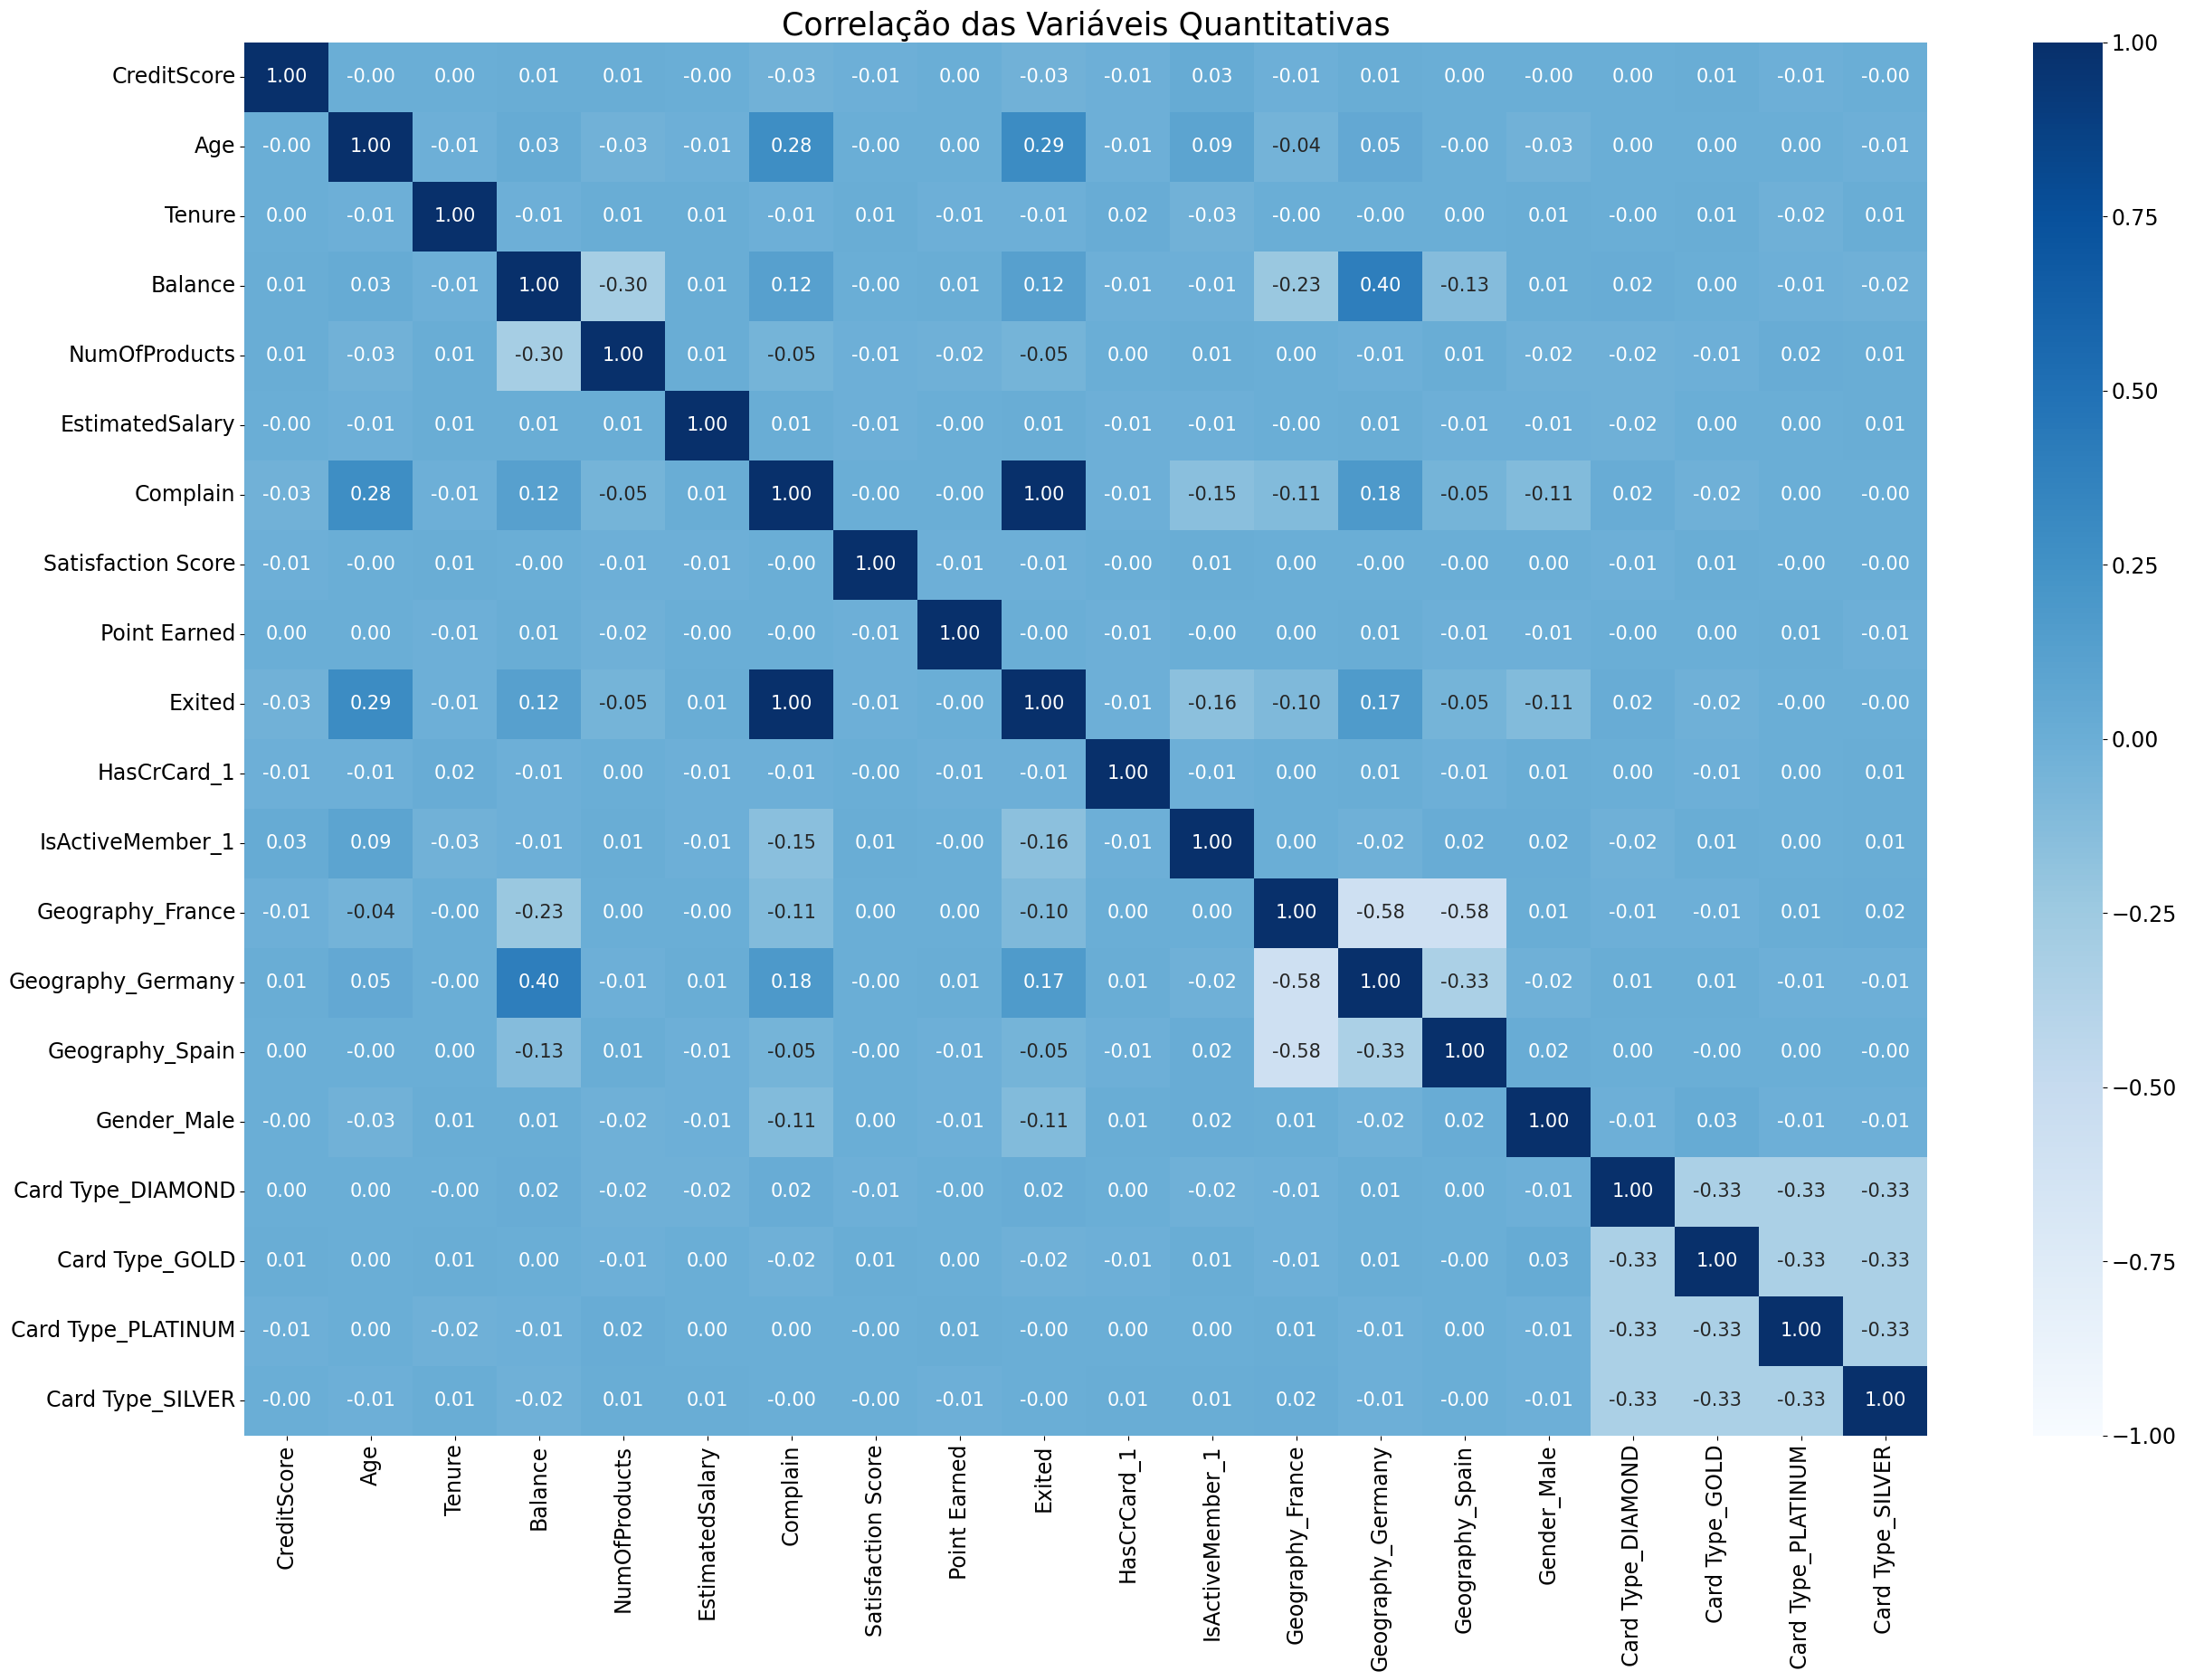

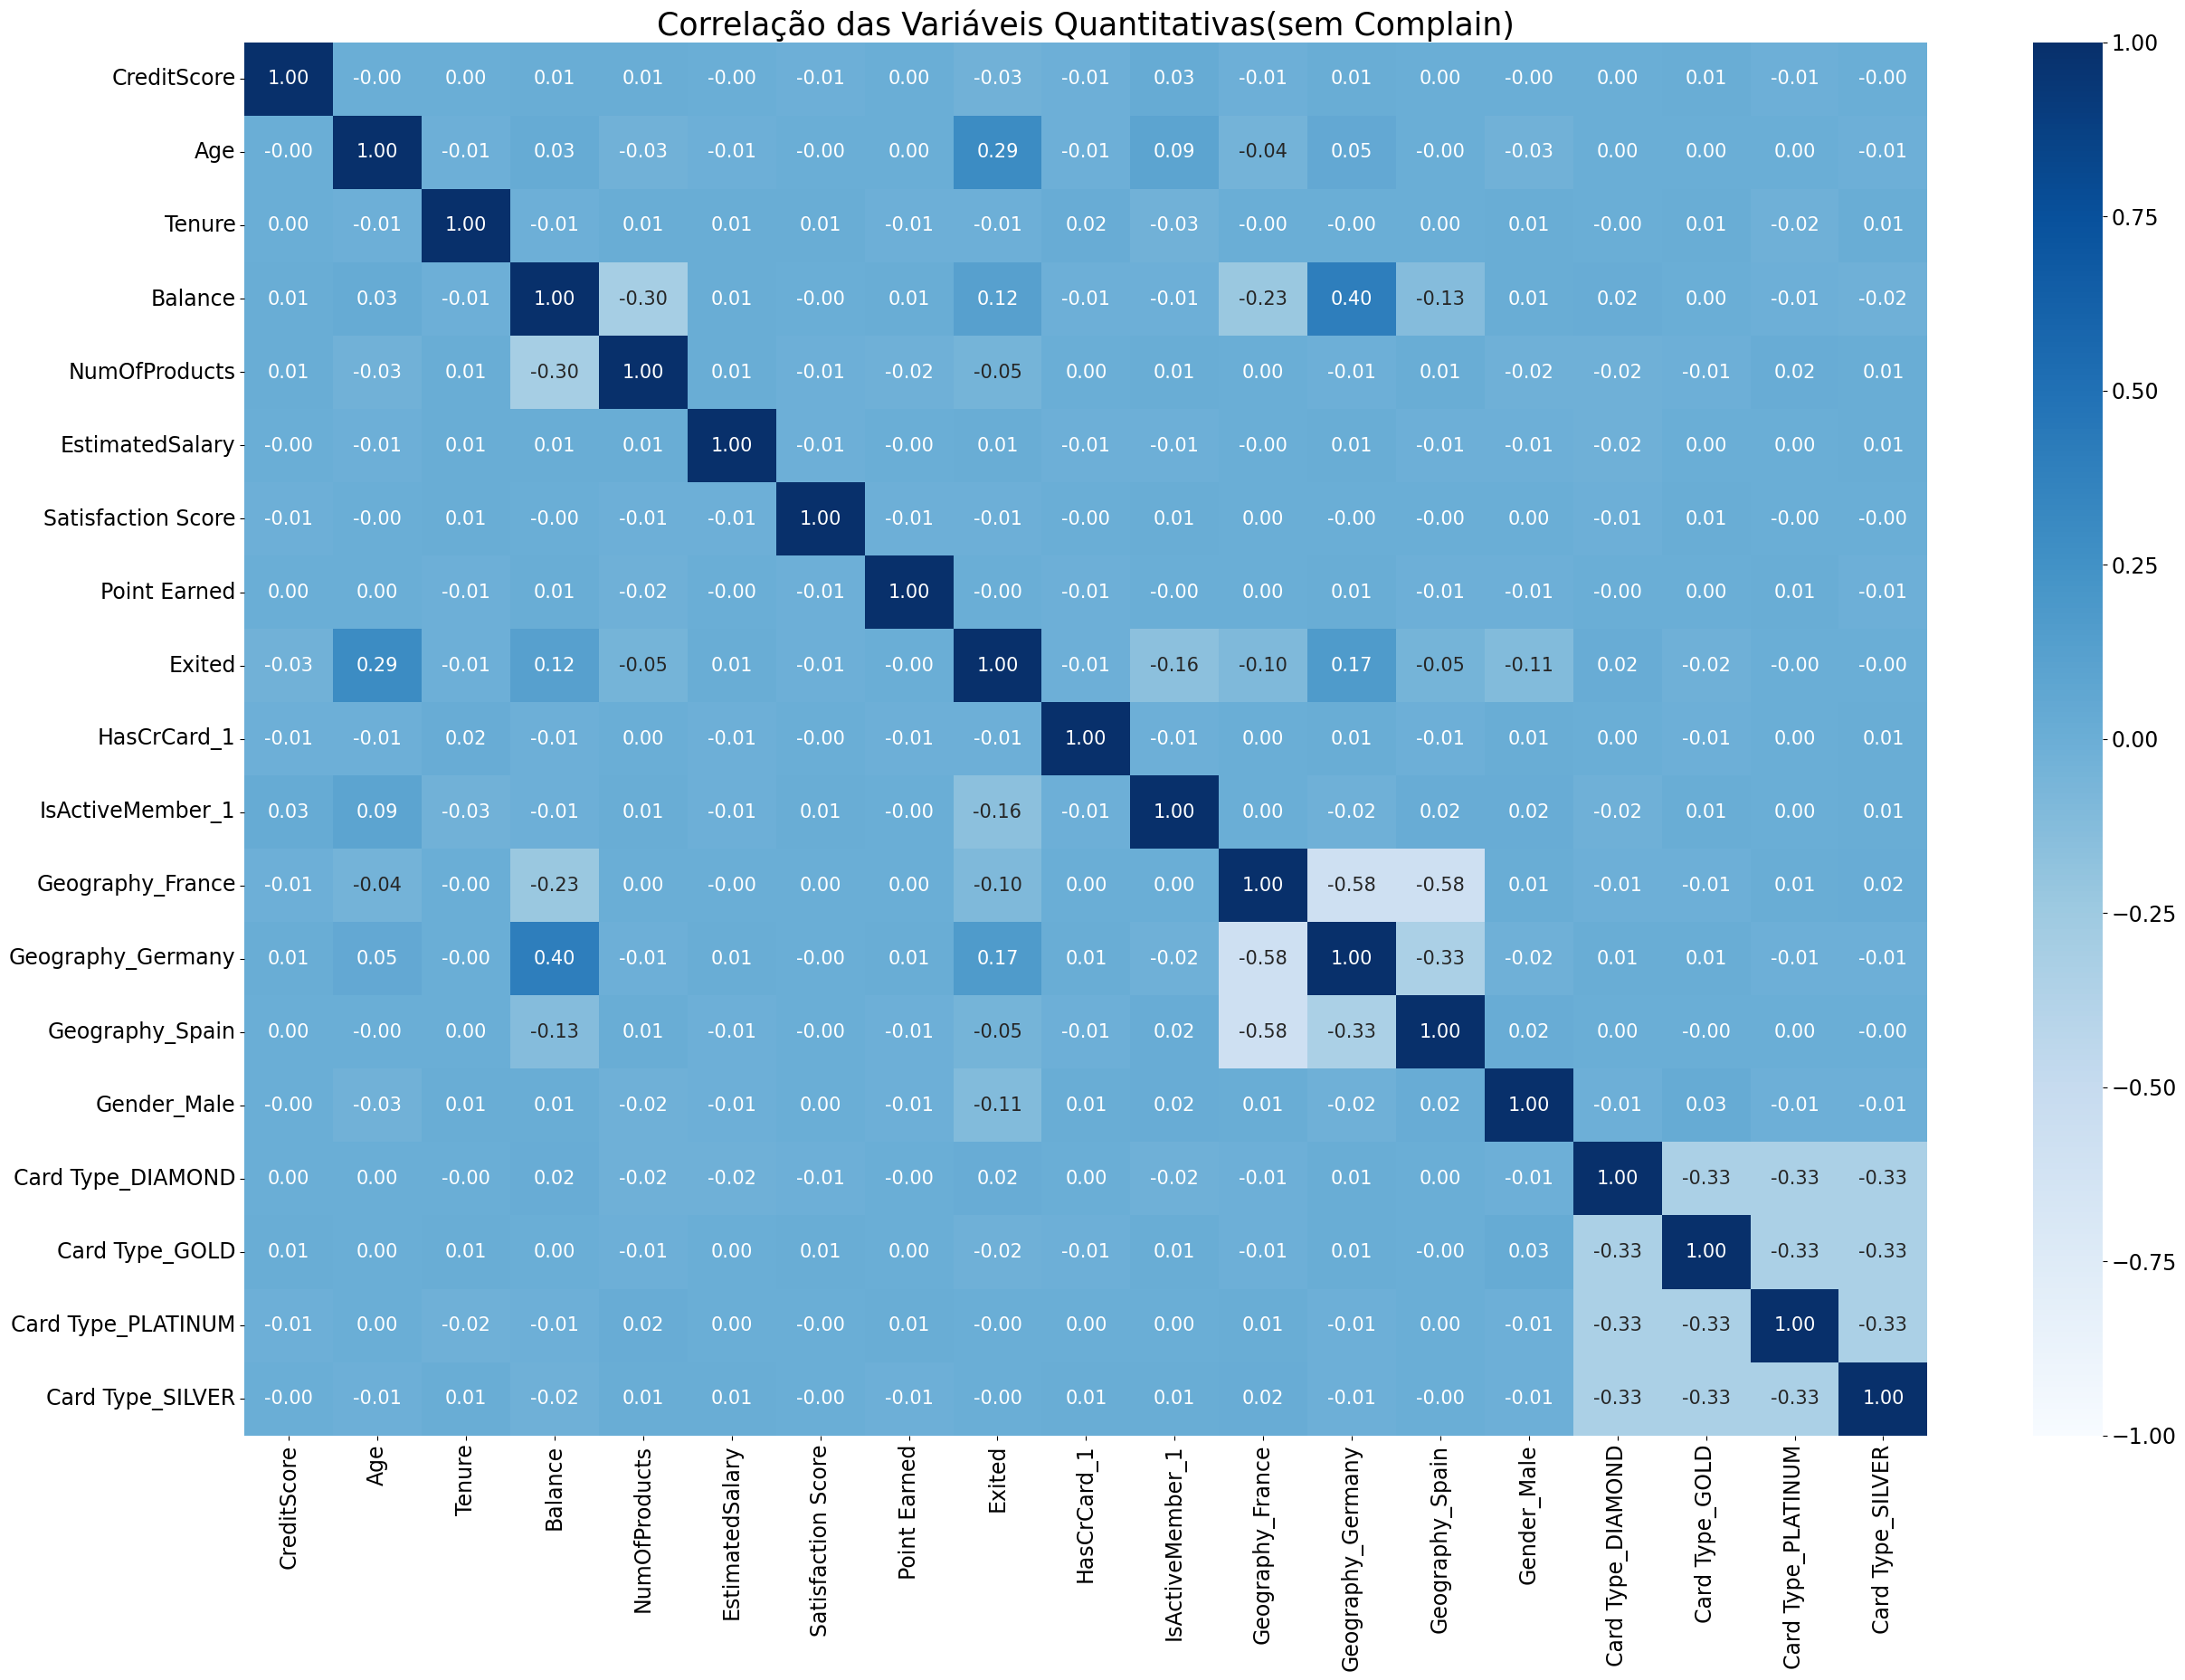

In [29]:
#%%Analises gráficas: correlação das variaveis Numéricas 

correlation_matrix = df_dummies.corr().round(2)
correlation_matrix

# Mapa de calor das variaveis quanti
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
                      cmap=plt.cm.Blues,
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.title('Correlação das Variáveis Quantitativas', fontsize=25)
plt.show()


#PALETAS ALTERNATIVAS 
# '_r' NO FINAL INVERTE AS CORES
# viridis - paleta boa para apresentar para pesssoas com problemas como daltonismo
# inferno
# magma
# cividis
# coolwarm
# Blues
# Greens
# Reds


#IMPORTANTE: variavel 'complain' apresentou correlação total (1) com avariavel alvo 'Exited' 
#vamos remove-la do modelo por enquanto mas ela sera preservada na base opriginal caso seja necessario


quali = quali.drop('Complain', axis=1)
df_dummies = df_dummies.drop('Complain', axis=1)


correlation_matrix2 = df_dummies.corr().round(2)
correlation_matrix2

# Mapa de calor das variaveis quanti (SEM COMPLAIN)
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix2, annot=True, fmt=".2f",
                      cmap=plt.cm.Blues,
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.title('Correlação das Variáveis Quantitativas(sem Complain)',fontsize=25)
plt.show()



In [30]:
#Separando as bases de Treino e Teste


df_dummies.dtypes

df_dummies['Exited'] = df_dummies['Exited'].astype('int64')


X = df_dummies .drop('Exited', axis=1)

y =  df_dummies['Exited']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



<ipython-input-31-fdd4c43b6c0c>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 2)


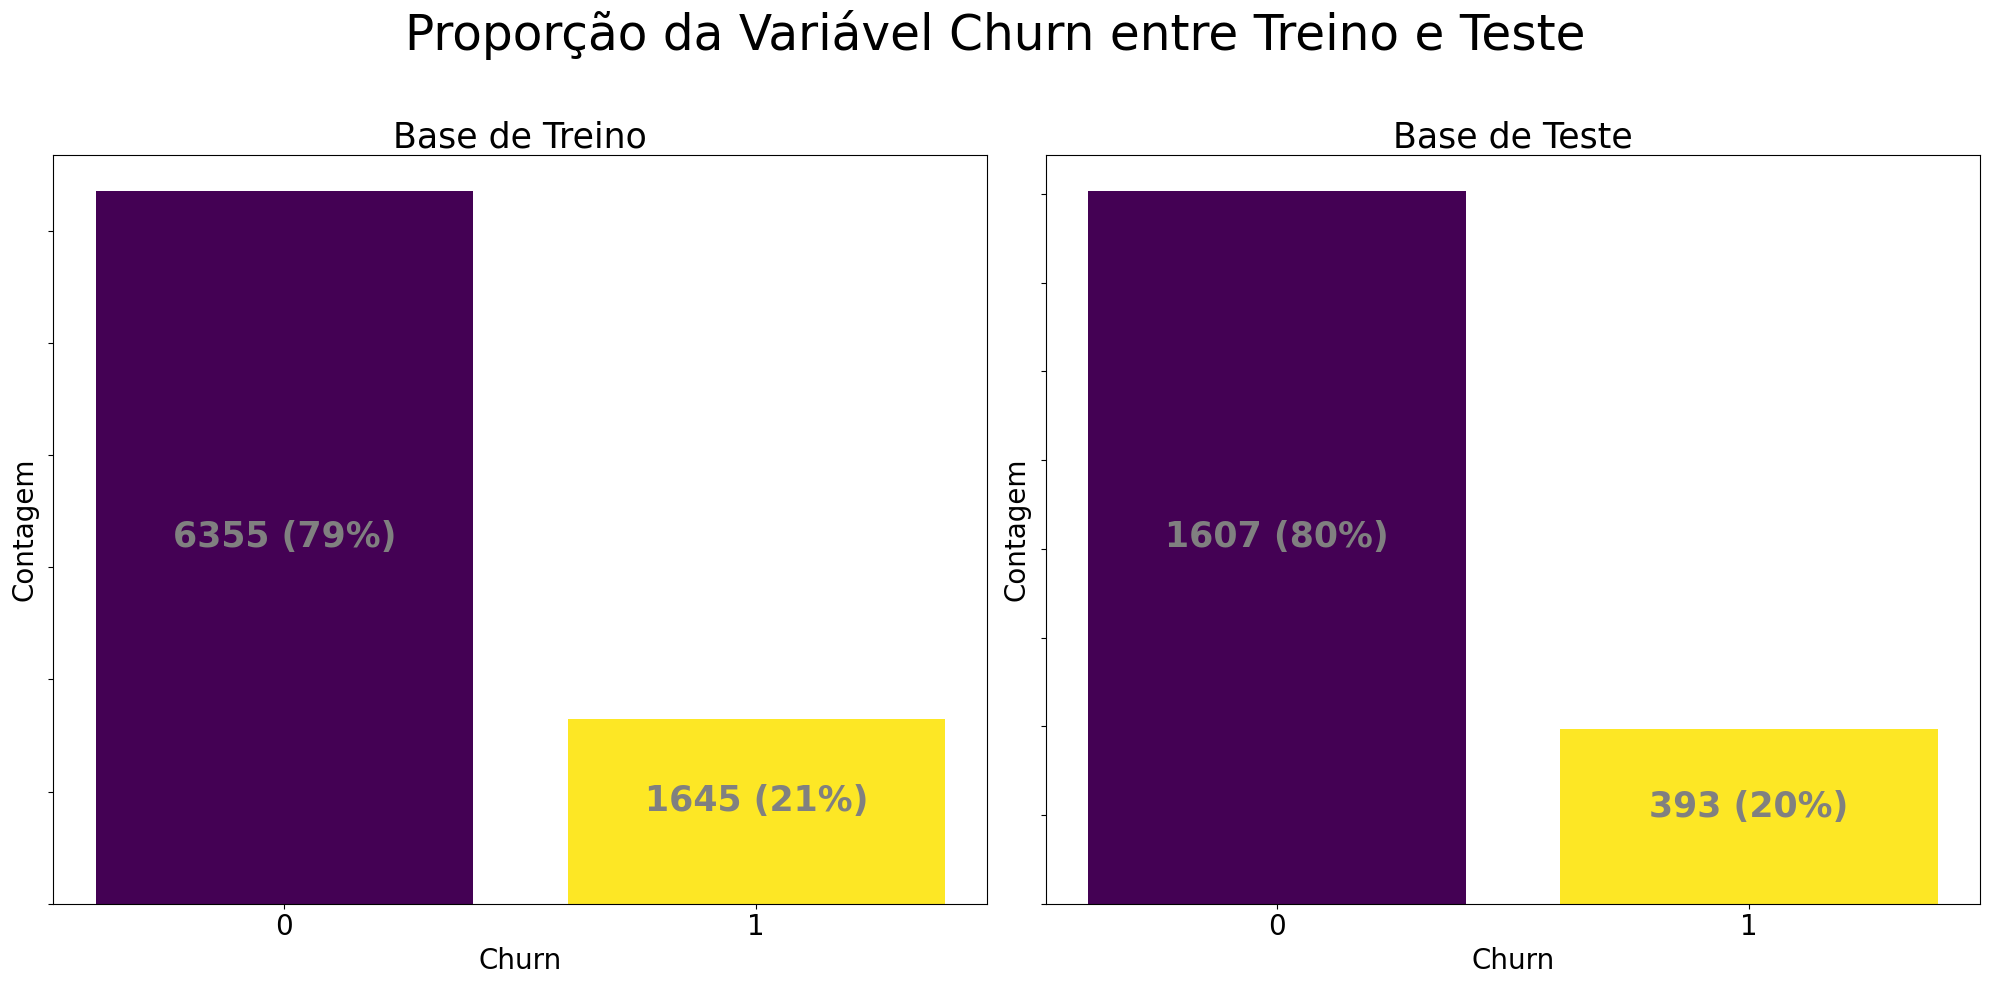

In [31]:
#verificando a proporcao de churn nas bases de treino e teste depois de separadas 
# Contando os valores 0 e 1 diretamente nas Series

churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()

# Criando o plot com subplots lado a lado e título principal
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Adicionando título geral ao plot
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)
cmap = cm.get_cmap('viridis', 2)
# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)

# Ocultando os valores do eixo y
axs[0].set_yticklabels([])

# Adicionando rótulos de dados nas barras da base de treino com valor absoluto e percentual
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  # Exibe o valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')
    
# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)

# Ocultando os valores do eixo y
axs[1].set_yticklabels([])

# Adicionando rótulos de dados nas barras da base de teste com valor absoluto e percentual
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  # Exibe o valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')
# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço para o título principal
plt.show()


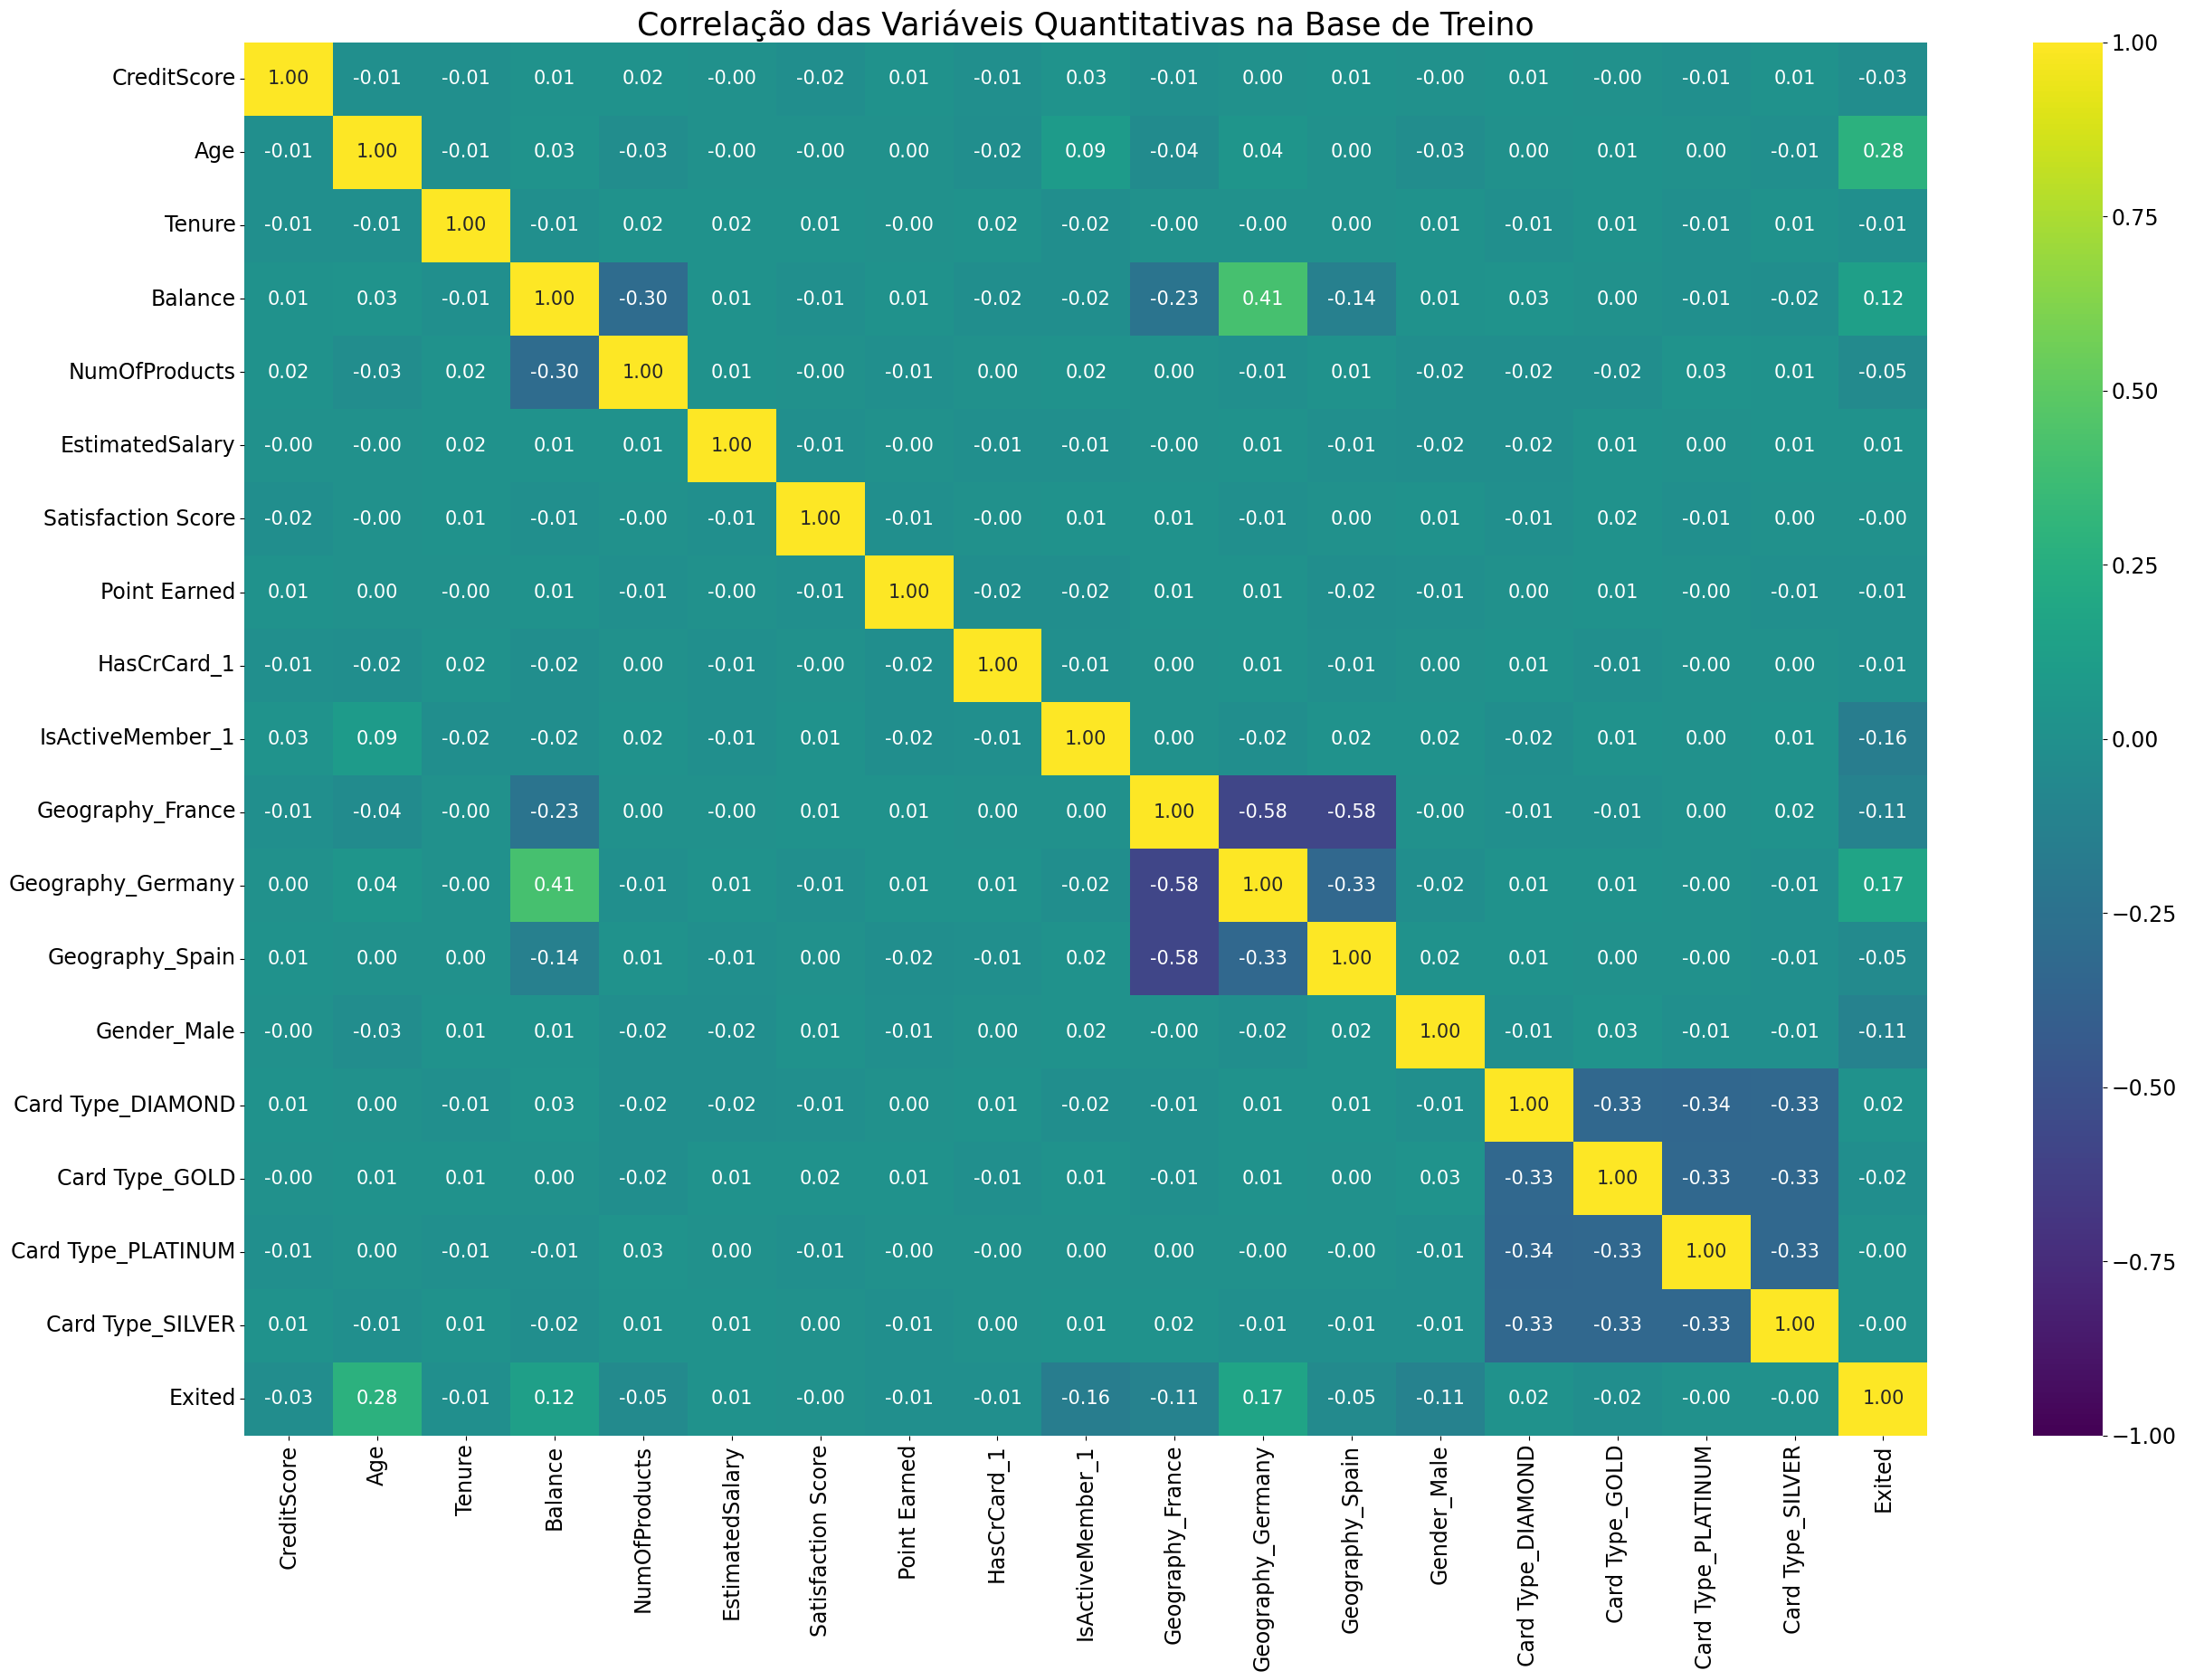

In [32]:
#%% Testando Multicolinearidade na base de treino


teste_multco_treino = pd.concat([X_train,y_train], axis = 1)


correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Mapa de calor das variaveis quanti (SEM COMPLAIN)
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis,
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

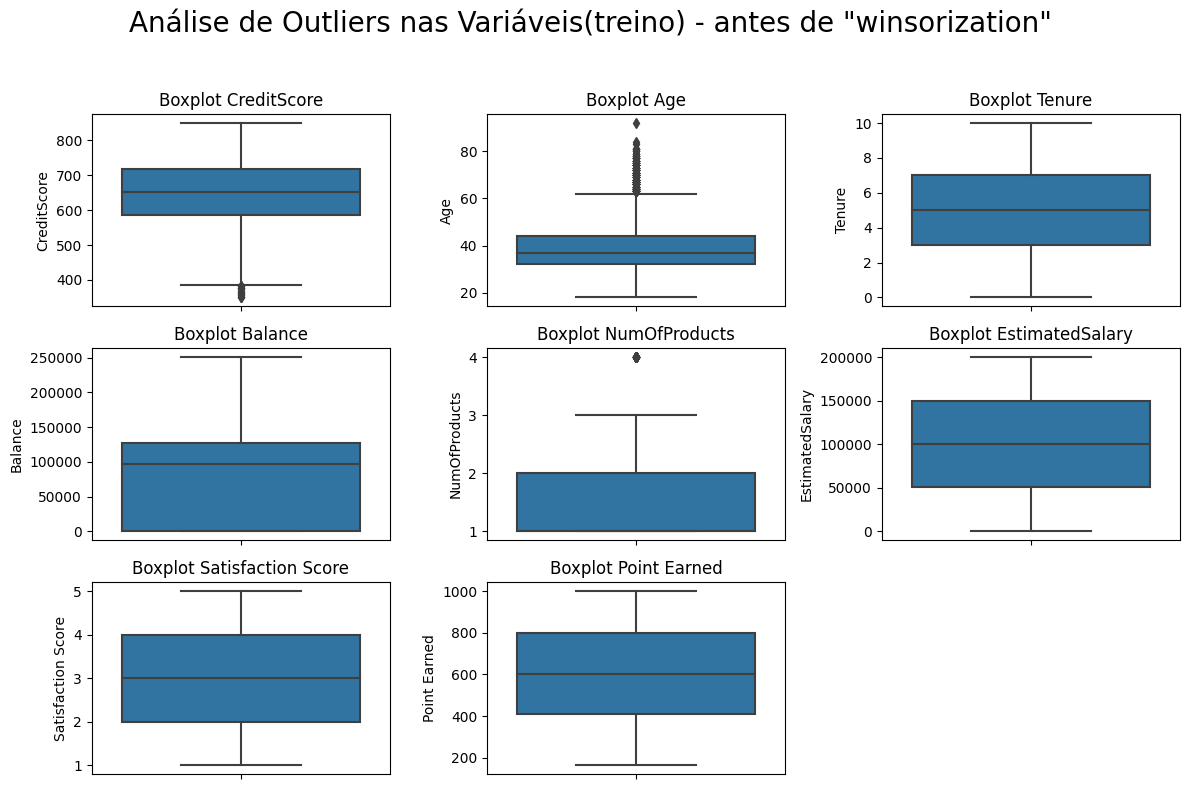

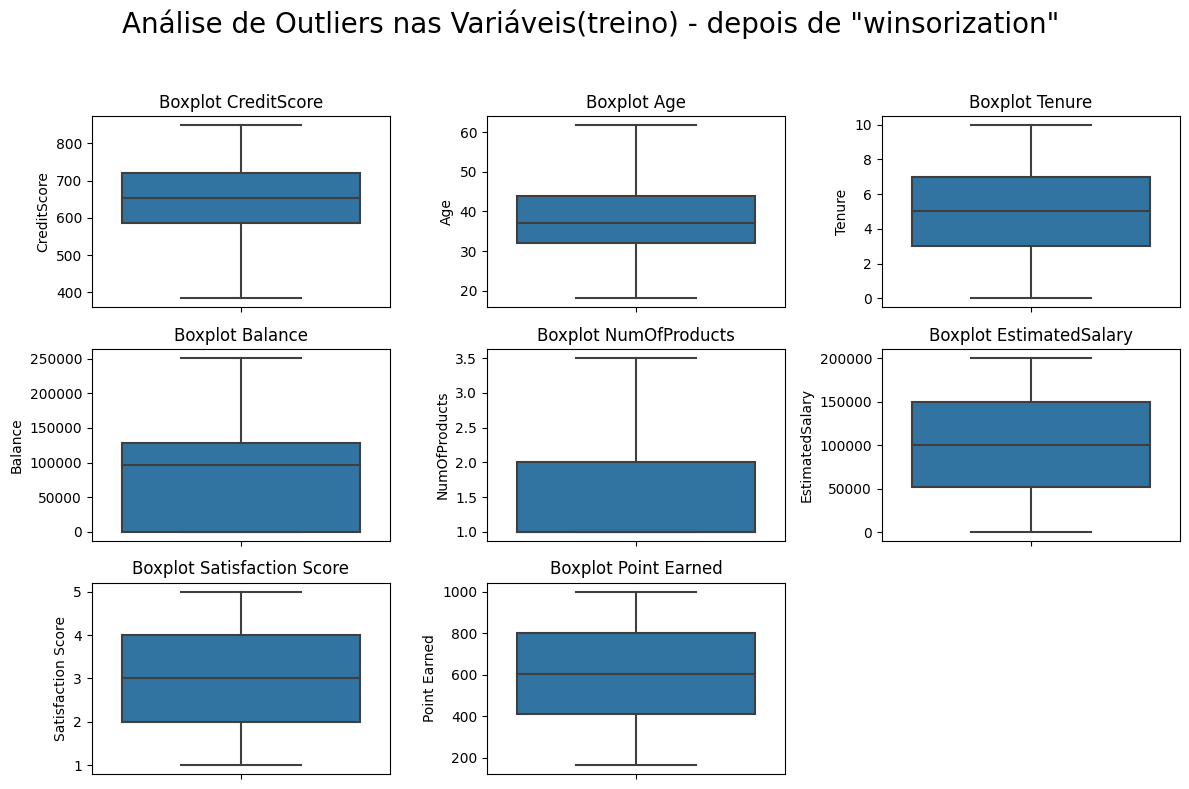

In [33]:
#%% analise de outliers das variaveis na base de treino 


# Criar uma lista com as variáveis de interesse
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned'
]

# Criar um subplot
plt.figure(figsize=(12, 8))

# Criar boxplots separados para cada variável
for i, var in enumerate(variaveis):
    plt.subplot(3, 3, i + 1)  # 3 linhas e 3 colunas
    sns.boxplot(y=teste_multco_treino[var])  # Usar o nome da variável diretamente
    plt.title(f'Boxplot {var}', fontsize=12)


# Adicionar título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout sem sobrepor o título
plt.show()




#aplicando procedimento de truncamento ou winsorization nos outliers
# ---> substitui os outliers pelos valores dos limites inferior e superior dos dados

# Função para tratar outliers
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Substituir outliers pelo limite
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])

# Aplicando a função nas variáveis desejadas
variaveis_para_tratar = ['Age', 'CreditScore', 'NumOfProducts']

for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)
# Criar um subplot
plt.figure(figsize=(12, 8))

# Criar boxplots separados para cada variável
for i, var in enumerate(variaveis):
    plt.subplot(3, 3, i + 1)  # 3 linhas e 3 colunas
    sns.boxplot(y=teste_multco_treino[var])  # Usar o nome da variável diretamente
    plt.title(f'Boxplot {var}', fontsize=12)

# Adicionar título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout sem sobrepor o título
plt.show()



In [34]:
#%% Separando novamente as bases de treino e teste depois de tratar os outliers APENAS na base de TREINO  
#treino

X_train=teste_multco_treino.drop('Exited', axis=1)
y_train=teste_multco_treino['Exited']

#teste

base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
X_test=base_corrige_teste.drop('Exited', axis=1)
y_test=base_corrige_teste['Exited']

print('---------------------------------------')
print(X_train.isnull().sum())
print('---------------------------------------')
print(X_train.dtypes)
print('---------------------------------------')
print(y_train.value_counts())
print('---------------------------------------')

---------------------------------------
CreditScore           0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
EstimatedSalary       0
Satisfaction Score    0
Point Earned          0
HasCrCard_1           0
IsActiveMember_1      0
Geography_France      0
Geography_Germany     0
Geography_Spain       0
Gender_Male           0
Card Type_DIAMOND     0
Card Type_GOLD        0
Card Type_PLATINUM    0
Card Type_SILVER      0
dtype: int64
---------------------------------------
CreditScore           float64
Age                   float64
Tenure                  int64
Balance               float64
NumOfProducts         float64
EstimatedSalary       float64
Satisfaction Score      int64
Point Earned            int64
HasCrCard_1             int64
IsActiveMember_1        int64
Geography_France        int64
Geography_Germany       int64
Geography_Spain         int64
Gender_Male             int64
Card Type_DIAMOND       int64
Card Type_GOLD          i

# Modelagem 


* Foram utilizadas técnicas de cross-validation, undersampling e normalização z-score nos dados.
   


# XGboost

------------------------
Cenário 2:Modelo XGboost com SMOTE
------------------------
------------------------
Tempo de Início: 2025-01-03 01:18:59.456375
------------------------
------------------------
Melhores parâmetros encontrados: {'learning_rate': 0.026739724716791546, 'max_depth': 8, 'n_estimators': 696, 'subsample': 0.5840447709584202, 'colsample_bytree': 0.9458577662130503, 'gamma': 0.5317110460512816, 'lambda': 5.644699934229905, 'alpha': 0.7855883431863273, 'min_child_weight': 1, 'scale_pos_weight': 8.833860514298356}
------------------------
------------------------

Acurácia por fold (Modelo XGBoost com SMOTE): [0.96362624 0.96508365 0.96505603 0.96269219 0.96483578 0.96465477]
Média da acurácia (Modelo XGBoost com SMOTE): 0.9643
------------------------
------------------------

Métricas do Conjunto de Treino (OOF) para o Modelo XGBoost:
ROC AUC: 0.9996
Precisão: 0.9440
Revocação: 1.0000
F1-Score: 0.9712
Acurácia: 0.9703
[[5978  377]
 [   0 6355]]
-----------------------

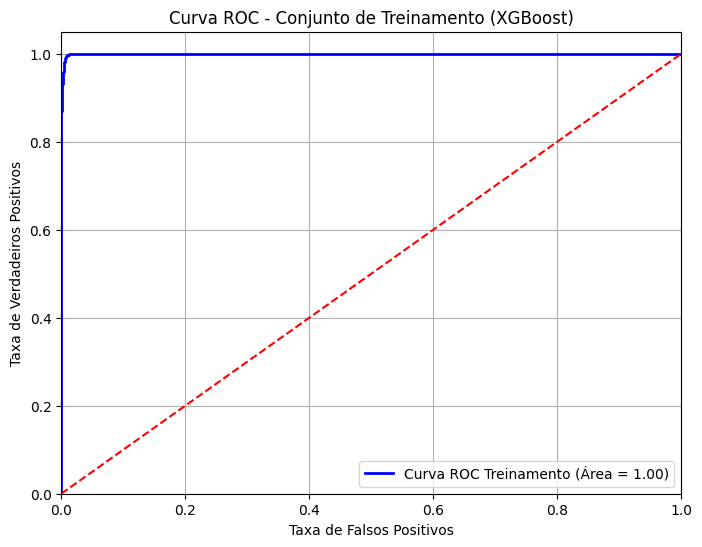

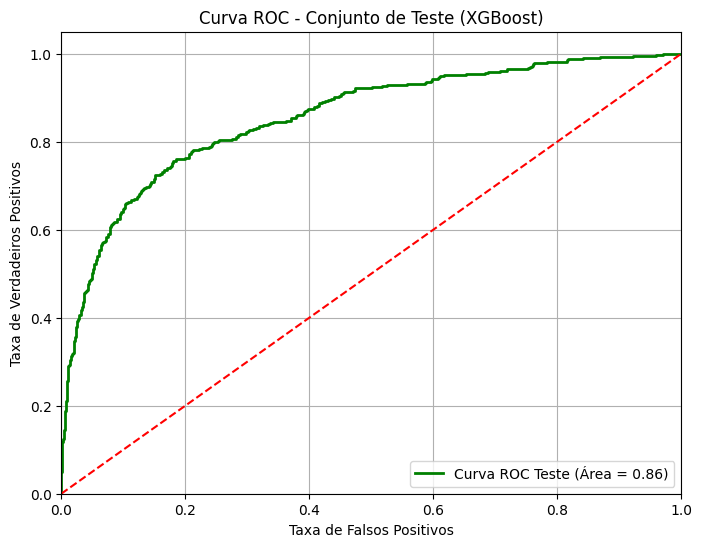

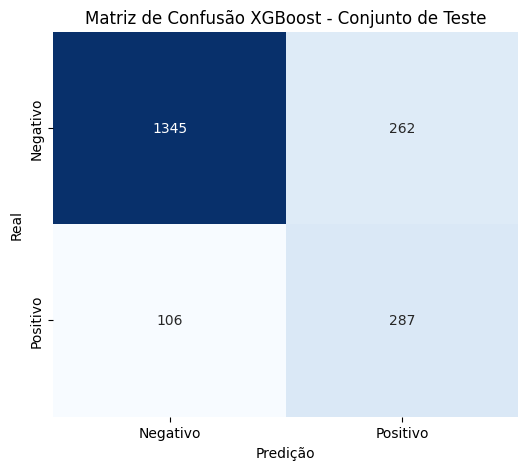

------------------------
Fim: 2025-01-03 01:30:35.796348
------------------------


In [46]:
#%% Modelo XGBoost com SMOTE

# === Configurações de log do Optuna ===
# Use apenas uma das opções abaixo, descomentando a desejada:

# 1. Mostrar apenas mensagens críticas (mensagens essenciais como erros graves)
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# 2. Mostrar apenas erros
# optuna.logging.set_verbosity(optuna.logging.ERROR)

# 3. Mostrar apenas avisos (oculta mensagens informativas)
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# 4. Mostrar todas as mensagens informativas (comportamento padrão)
# optuna.logging.set_verbosity(optuna.logging.INFO)

# 5. Mostrar mensagens detalhadas para depuração
# optuna.logging.set_verbosity(optuna.logging.DEBUG)

# === Suprimir todos os warnings === (isso é para deixar o notebook mais limpo, vale tirar quando desejar 
                                    #fazer qualquer diagnostico, aqui sei que esta tudo ok por enquanto ])
warnings.filterwarnings("ignore")

# === Redirecionar saída padrão e erros para evitar mensagens adicionais ===
f = open(os.devnull, 'w')
os.dup2(f.fileno(), 1)  # Redireciona stdout (saída padrão)
os.dup2(f.fileno(), 2)  # Redireciona stderr (saída de erros)

print('------------------------')
print("Cenário 2:Modelo XGboost com SMOTE")
print('------------------------')

# início
print('------------------------')
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print("Tempo de Início:", start_time_utc)
print('------------------------')

# Definir o espaço de busca para os hiperparâmetros do XGBoost
def objective(trial):
    # Hiperparâmetros
    params = {
        'objective': 'binary:logistic',  # Modelo de classificação binária
        'eval_metric': 'auc',  # Métrica de avaliação para maximizar AUC ROC
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Taxa de aprendizado
        'max_depth': trial.suggest_int('max_depth', 4, 8),  # Reduzir a profundidade das árvores
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),  # Número de estimadores
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Amostragem dos dados
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # Amostragem das características
        'gamma': trial.suggest_float('gamma', 0, 5.0),  # Regularização do ganho mínimo no split
        'lambda': trial.suggest_float('lambda', 0.1, 10.0),  # Regularização L2 (Ridge)
        'alpha': trial.suggest_float('alpha', 0.1, 10.0),  # Regularização L1 (Lasso)
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),  # Tamanho mínimo das folhas
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # Ajuste para classes desbalanceadas
        #'tree_method': 'gpu_hist',  # Usar GPU  USAR COM AS MAQUINAS MAIS FORTES DO KAGGLE GPU-P100
        'tree_method': 'hist',  # Usar CPU normal
        'verbose': 0  # Desativar verbosidade para evitar sobrecarga de logs
    }
    
    
    # Passo 1: Aplicar o SMOTE para balancear os dados
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # Passo 2: Normalizar os Dados de Treinamento
    scaler = StandardScaler()
    X_smote_scaled = scaler.fit_transform(X_smote)
    
    # Passo 3: Rodar a Validação Cruzada e obter predições OOF para o modelo XGBoost
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    xgb_model = xgb.XGBClassifier(**params, device='cuda', n_jobs=-1)
    
    # Obter as predições OOF
    y_pred_oof_xgb = cross_val_score(xgb_model, X_smote_scaled, y_smote, cv=kf, scoring='roc_auc', error_score='raise').mean()
    
    return y_pred_oof_xgb  # Maximizar o F1-Score

# Definir o estudo com Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Número de iterações de otimização

# Melhor conjunto de parâmetros encontrado
print('------------------------')
best_params = study.best_params
print(f"Melhores parâmetros encontrados: {best_params}")
print('------------------------')

# Passo 4: Rodar o modelo XGBoost com os melhores parâmetros encontrados
xgb_model = xgb.XGBClassifier(**best_params, tree_method='hist', device='cuda', n_jobs=-1)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote)

# Validar com os dados balanceados
kf = StratifiedKFold(n_splits=6, shuffle=True)
cv_results_xgb = cross_val_score(xgb_model, X_smote_scaled, y_smote, cv=kf, scoring='roc_auc') # era f1 ( opcoes---> Acurácia: "accuracy" , Precisão: "precision", Recall: "recall", F1-Score: "f1", curva ROC AUC: "roc_auc") 

# Exibir os resultados da validação cruzada do modelo XGBoost
print('------------------------')
print(f'\nAcurácia por fold (Modelo XGBoost com SMOTE): {cv_results_xgb}')
print(f'Média da acurácia (Modelo XGBoost com SMOTE): {cv_results_xgb.mean():.4f}')
print('------------------------')

# Passo 5: Obter as predições no conjunto de treino (OOF)
y_pred_oof_xgb = xgb_model.fit(X_smote_scaled, y_smote).predict_proba(X_smote_scaled)[:, 1]

# Cálculo das métricas no conjunto de treino (OOF) para o modelo XGBoost
roc_auc_oof_xgb = roc_auc_score(y_smote, y_pred_oof_xgb)
precision_oof_xgb = precision_score(y_smote, (y_pred_oof_xgb > 0.5).astype(int))
recall_oof_xgb = recall_score(y_smote, (y_pred_oof_xgb > 0.5).astype(int))
f1_oof_xgb = f1_score(y_smote, (y_pred_oof_xgb > 0.5).astype(int))
accuracy_oof_xgb = accuracy_score(y_smote, (y_pred_oof_xgb > 0.5).astype(int))
conf_matrix_train_xgb = confusion_matrix(y_smote, xgb_model.predict(X_smote_scaled))

# Exibir as métricas do conjunto de treino (OOF) para o modelo XGBoost
print('------------------------')
print("\nMétricas do Conjunto de Treino (OOF) para o Modelo XGBoost:")
print(f"ROC AUC: {roc_auc_oof_xgb:.4f}")
print(f"Precisão: {precision_oof_xgb:.4f}")
print(f"Revocação: {recall_oof_xgb:.4f}")
print(f"F1-Score: {f1_oof_xgb:.4f}")
print(f"Acurácia: {accuracy_oof_xgb:.4f}")
print(conf_matrix_train_xgb)
print('------------------------')
# Passo 6: Obter as predições no conjunto de teste
X_test_scaled = scaler.transform(X_test)  # Normalizar os dados de teste
y_pred_test_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Cálculo das métricas no conjunto de teste para o modelo XGBoost
roc_auc_test_cenario2_xgb = roc_auc_score(y_test, y_pred_test_xgb)
precision_test_cenario2_xgb = precision_score(y_test, (y_pred_test_xgb > 0.5).astype(int))
recall_test_cenario2_xgb = recall_score(y_test, (y_pred_test_xgb > 0.5).astype(int))
f1_test_cenario2_xgb = f1_score(y_test, (y_pred_test_xgb > 0.5).astype(int))
accuracy_test_cenario2_xgb = accuracy_score(y_test, (y_pred_test_xgb > 0.5).astype(int))
conf_matrix_test_cenario2_xgb = confusion_matrix(y_test, (y_pred_test_xgb > 0.5).astype(int)) 
# Exibir as métricas do conjunto de teste para o modelo XGBoost
print('------------------------')
print("\nMétricas do Conjunto de Teste para o Modelo XGBoost (Cenário 2):")
print(f"ROC AUC: {roc_auc_test_cenario2_xgb:.4f}")
print(f"Acurácia: {accuracy_test_cenario2_xgb:.4f}")
print(f"Precisão: {precision_test_cenario2_xgb:.4f}")
print(f"Revocação: {recall_test_cenario2_xgb:.4f}")
print(f"F1-Score: {f1_test_cenario2_xgb:.4f}")
print('------------------------')
print('------------------------')
print("Matriz de Confusão:")
print(conf_matrix_test_cenario2_xgb)
print('------------------------')


# Passo 7: Plotar a curva ROC usando o conjunto de treino (OOF)
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_smote, y_pred_oof_xgb)
roc_auc_train_xgb = auc(fpr_train_xgb, tpr_train_xgb)

# Curva ROC para o conjunto de teste
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_pred_test_xgb)  # Usar y_test e y_pred_test_xgb
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

# Gráfico da curva ROC para o conjunto de treino
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', lw=2, label='Curva ROC Treinamento (Área = {:.2f})'.format(roc_auc_train_xgb))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Conjunto de Treinamento (XGBoost)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Gráfico da curva ROC para o conjunto de teste
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_xgb, tpr_test_xgb, color='green', lw=2, label='Curva ROC Teste (Área = {:.2f})'.format(roc_auc_test_xgb))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Conjunto de Teste (XGBoost)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plotar a Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test_cenario2_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title("Matriz de Confusão XGBoost - Conjunto de Teste")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.show()  # Exibir o gráfico sem salvar a imagem




# Tempo total de execução
# fim
t_end = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Fim:", t_end)
print('------------------------')